### Analysis Notebook
This notebook pulls in data from the `data_intermediate` folder to generate visualizations and models of air quality and the effects of wildfires

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(["seaborn-darkgrid", "seaborn-colorblind", "seaborn-notebook"])
if ".." not in sys.path: sys.path.insert(0,"..")
# sys.path.insert(os.path.dirname(find_dotenv()))

/var/folders/4f/fzllrn4502l9flldxbwxtf9m0000gn/T/ipykernel_72362/2711770444.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use(["seaborn-darkgrid", "seaborn-colorblind", "seaborn-notebook"])
/var/folders/4f/fzllrn4502l9flldxbwxtf9m0000gn/T/ipykernel_72362/2711770444.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use(["seaborn-darkgrid", "seaborn-colorblind", "seaborn-notebook"])
/var/folders/4f/fzllrn4502l9flldxbwxtf9m0000gn/T/ipykernel_72362/2711770444.py:9: MatplotlibDeprecationWarning: The seaborn 

In [3]:
fire_assignments = pd.read_excel("../data_raw/Wildfire Cities Assignments.xlsx")
assignment = fire_assignments[fire_assignments['LastName'] == "Yip"]
assignment
city_coordinates = [46.8721, -113.9940]

In [4]:
fire_gdf = gpd.read_file('../data_intermediate/wildfire_combine.geojson', engine='pyogrio')
smoke_estimate_df = pd.read_csv('../data_intermediate/smoke_estimate.csv')
aqi_df = pd.read_csv('../data_intermediate/avg_aqi_per_year2.csv')

## Step 2: Visualization

### 1. Wildfire histogram

In [5]:
distances = fire_gdf[['OBJECTID', 'distances']]

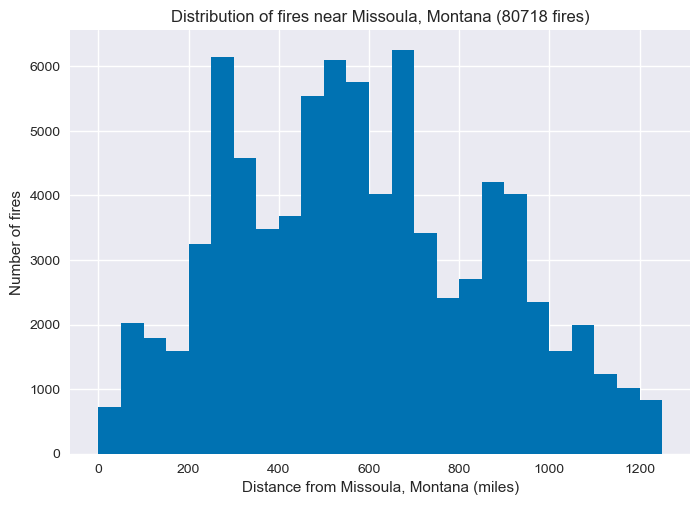

In [6]:
fig, ax = plt.subplots()
plt.hist(distances['distances'], bins=[x for x in range(0, 1251, 50)])
plt.ylabel('Number of fires')
plt.xlabel('Distance from Missoula, Montana (miles)')
plt.title(f'Distribution of fires near Missoula, Montana ({distances.shape[0]} fires)')
plt.show()

### 2. Time Series graph:
Next I will generate a time series graph showing the total acres burned per year by fires near Missoula, Montana

In [7]:
acres_burned_per_year = fire_gdf[['GIS_Acres', 'Fire_Year']].groupby('Fire_Year').sum().reset_index()

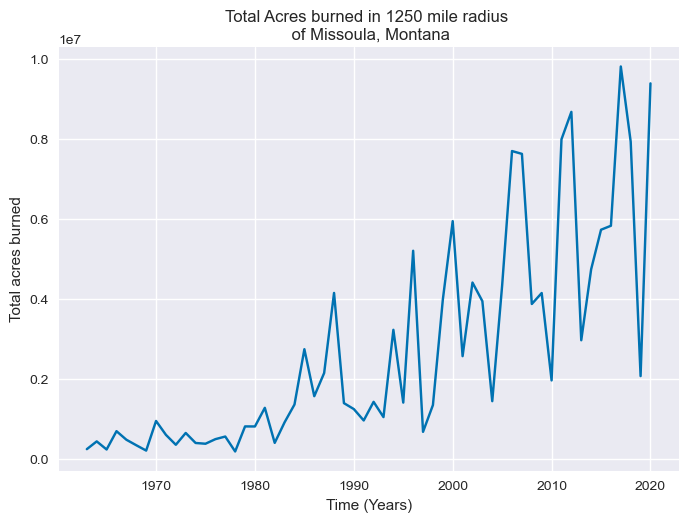

In [8]:
fig, ax = plt.subplots()
plt.plot(acres_burned_per_year['Fire_Year'], acres_burned_per_year['GIS_Acres'])
plt.xlabel('Time (Years)')
plt.ylabel('Total acres burned')
plt.title('Total Acres burned in 1250 mile radius \n of Missoula, Montana')
plt.show()

### 3. Fire Smoke Estimate and AQI Estimate
Because the two estimates of air quality are vastly different I will scale them to both be within the range of 0-1 

The two scaling methods I will use is the Standard Scaler method and the Min Max Scaler method. Shown in this article here https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35, we know that Standard Scaler works assumes the data is normally distributed. In contrast the min max scaler works on non-normally distributed variables. Below I will implement these as functions. 

In [9]:
def MinMaxScaler(df, columns, upper_bound=1, lower_bound=0):
    for col in columns:
        max_val = df[col].max()
        min_val = df[col].min()
        x_minmax = (df[col] - min_val) / (max_val - min_val)
        df[f"{col}_scaled"] = x_minmax * (upper_bound - lower_bound) + lower_bound
    return df

def StandardScaler(df, columns):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        df[f"{col}_scaled"] = (df[col] - mean) / sd
    return df

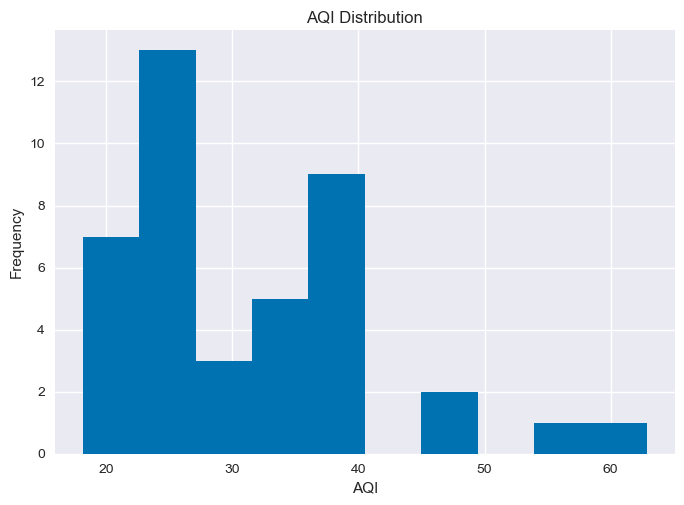

In [10]:
fig, ax = plt.subplots()
plt.hist(aqi_df['aqi'])
plt.title("AQI Distribution")
plt.ylabel("Frequency")
plt.xlabel("AQI")
plt.show()

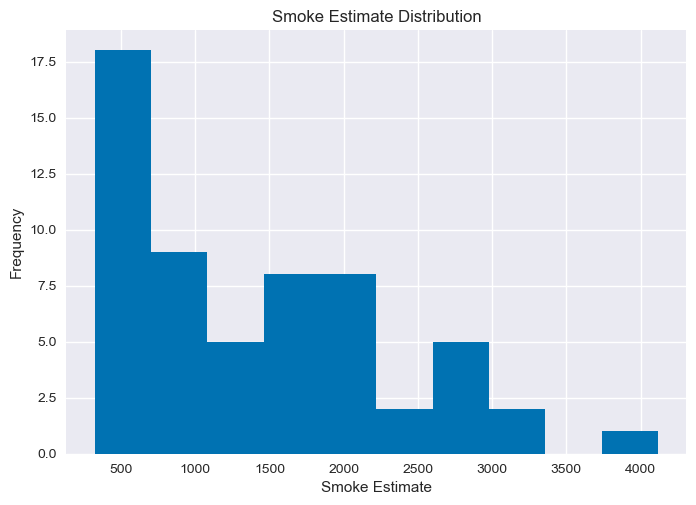

In [11]:
fig, ax = plt.subplots()
plt.hist(smoke_estimate_df['smoke_estimate'])
plt.title("Smoke Estimate Distribution")
plt.ylabel("Frequency")
plt.xlabel("Smoke Estimate")
plt.show()

Now we will scale these estimates and look at the distributions.

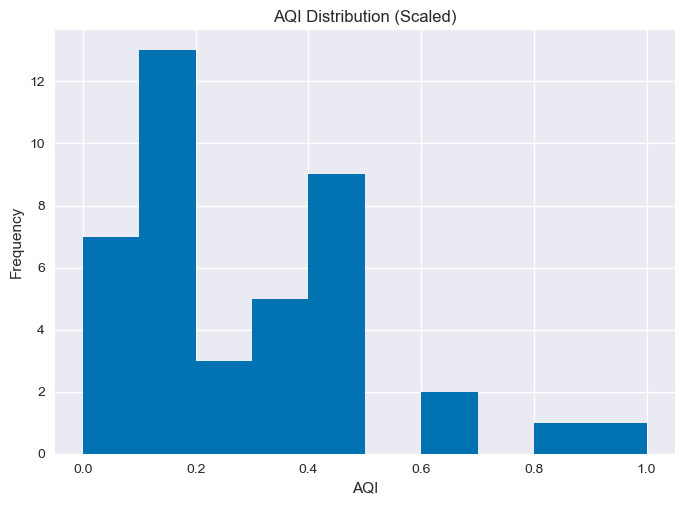

In [12]:
aqi_scaled = MinMaxScaler(aqi_df, ['aqi'])
fig, ax = plt.subplots()
plt.hist(aqi_scaled['aqi_scaled'])
plt.title("AQI Distribution (Scaled)")
plt.ylabel("Frequency")
plt.xlabel("AQI")
plt.show()

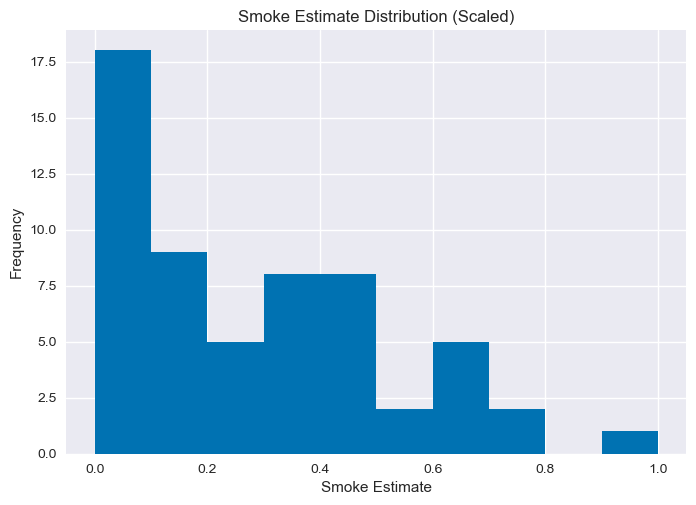

In [13]:
smoke_estimate_scaled = MinMaxScaler(smoke_estimate_df, ['smoke_estimate'])
fig, ax = plt.subplots()
plt.hist(smoke_estimate_scaled['smoke_estimate_scaled'])
plt.title("Smoke Estimate Distribution (Scaled)")
plt.ylabel("Frequency")
plt.xlabel("Smoke Estimate")
plt.show()

Finally we will compare our air quality index estimates on a time series plot below:

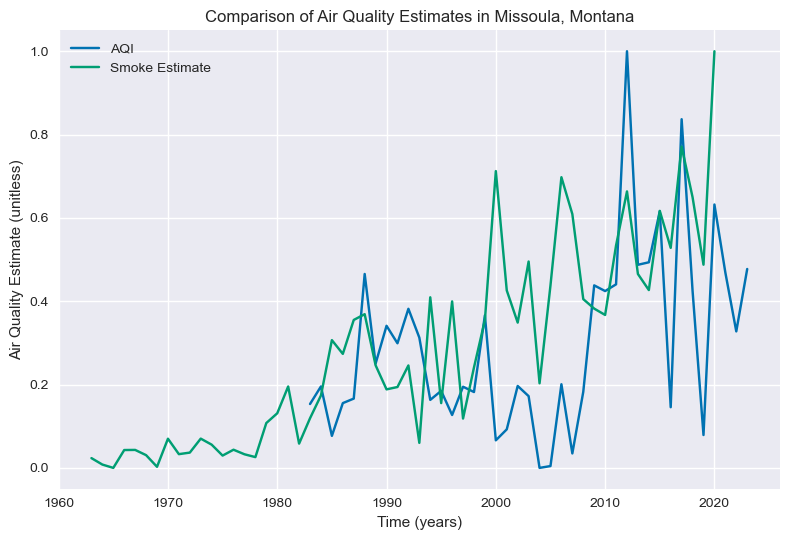

In [14]:
fig, ax = plt.subplots()
plt.plot(aqi_scaled['year'], aqi_scaled['aqi_scaled'], label='AQI')
plt.plot(smoke_estimate_scaled['year'], smoke_estimate_scaled['smoke_estimate_scaled'], label='Smoke Estimate')
plt.xlabel('Time (years)')
plt.ylabel('Air Quality Estimate (unitless)')
plt.title('Comparison of Air Quality Estimates in Missoula, Montana')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
years_list = set(aqi_scaled['year']) & set(smoke_estimate_scaled['year'])
aqi_scaled_subset = aqi_scaled[aqi_scaled['year'].isin(years_list)].reset_index()
se_scaled_subset = smoke_estimate_scaled[smoke_estimate_scaled['year'].isin(years_list)].reset_index()

For fun, lets run a linear regression and look at the correlation coefficient. How much variation in AQI can be explained by my smoke estimate?

In [16]:
model = sm.OLS(se_scaled_subset['smoke_estimate_scaled'].to_numpy(), aqi_scaled_subset['aqi_scaled'].to_numpy())
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.679
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              78.33
Date:                Wed, 08 Nov 2023   Prob (F-statistic):                    1.15e-10
Time:                        22:48:17   Log-Likelihood:                         -2.3602
No. Observations:                  38   AIC:                                      6.720
Df Residuals:                      37   BIC:                                      8.358
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the above result we can see that my smoke estimate does a decent job! 67.9 % of the variation is explained!

### 4. Smoke prediction model

The first step is to generate a set of numerical features that we can build a model on. I will use the same features that I used in my original smoke estimate.

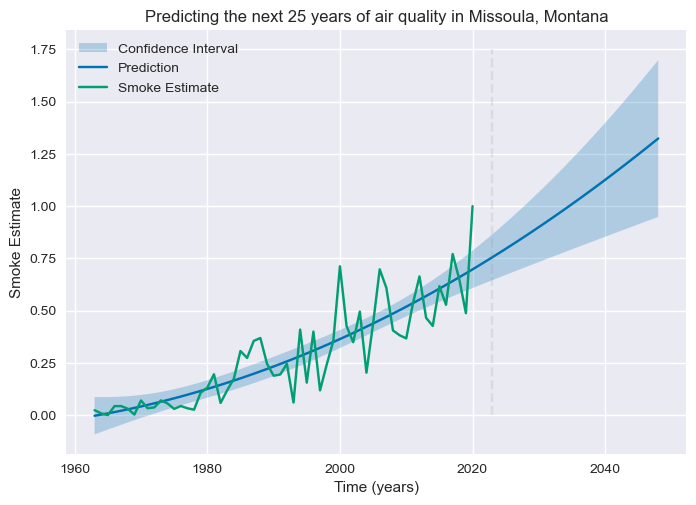

In [17]:
df = smoke_estimate_scaled[['year', 'smoke_estimate_scaled']]
df = sm.add_constant(df)
model = 'smoke_estimate_scaled ~ I(year**2) + year'
result = smf.ols(formula=model, data=df).fit()


x_pred = pd.DataFrame({'year':list(range(1963, 2049, 1))})
pred_results = result.get_prediction(x_pred)

y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred, y_pred, label='Prediction')
plt.plot(df.year, df.smoke_estimate_scaled, label='Smoke Estimate')
plt.vlines(x=2023, ymin=0, ymax = 1.75, linestyles='dashed', colors='grey', alpha=0.15)
plt.title('Predicting the next 25 years of air quality in Missoula, Montana')
plt.xlabel('Time (years)')
plt.ylabel('Smoke Estimate')
plt.legend(loc='upper left')
plt.show()